# Import libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import pickle
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
import os
import warnings
warnings.filterwarnings("ignore")

# Set Constants

In [2]:
file_path = "610_ps4_training\\610_ps4_training\\trainingT2HAR\\har_train.csv"
model_path = "models\\t2"
random_seed = 42

# Read Data

In [3]:
train_data = pd.read_csv(file_path, header=None)

## Find number of columns and rows with NaN entries

In [4]:
print(np.count_nonzero(train_data.isnull().any().sum()))

0


We see that we have no NaN value which is good

## Splitting data into train, tune and validate

In [5]:
X_train, X_tune, y_train, y_tune = train_test_split(train_data.iloc[:,:-1], train_data.iloc[:,-1], test_size=0.10, random_state=random_seed, stratify= train_data.iloc[:,-1])
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.10, random_state=random_seed, stratify= y_train)

# resetting index
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_tune = X_tune.reset_index(drop=True)
y_tune = y_tune.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# delete data dataframe to save memory
train_data = train_data.iloc[0:0]

print("Train data shape = ",X_train.shape)
print("Train ground truth shape = ",y_train.shape)
print("Tune data shape = ",X_tune.shape)
print("Tune ground truth shape = ",y_tune.shape)
print("Test data shape = ",X_test.shape)
print("Test ground truth shape = ",y_test.shape)

Train data shape =  (1977, 328)
Train ground truth shape =  (1977,)
Tune data shape =  (245, 328)
Tune ground truth shape =  (245,)
Test data shape =  (220, 328)
Test ground truth shape =  (220,)


# Exploring data

##  Get statistics of columns

In [6]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,318,319,320,321,322,323,324,325,326,327
count,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000,1.977000e+03,1977.000000,1977.000000,1977.000000,1977.000000,...,1.977000e+03,1.977000e+03,1.977000e+03,1.977000e+03,1977.000000,1977.000000,1.977000e+03,1.977000e+03,1.977000e+03,1.977000e+03
mean,0.174386,56.498599,0.395613,0.287810,0.499826,1.822850e+00,0.029870,-76.640110,19.728423,8.051911,...,4.285714e-01,3.333333e-01,4.761905e-02,9.523810e-02,0.054628,0.601922,3.809524e-01,3.333333e-01,2.857143e-01,2.380952e-01
std,0.396050,114.788186,0.317586,1.298402,0.052124,5.341645e+00,0.042038,143.334024,83.734542,13.433760,...,9.772434e-15,2.554159e-15,2.193245e-15,4.386490e-15,0.565587,3.223122,1.749044e-14,2.554159e-15,3.886764e-16,2.581922e-15
min,0.000000,-574.017018,0.002734,0.000000,0.110307,0.000000e+00,0.000000,-1924.085961,-358.065291,0.000405,...,4.285714e-01,3.333333e-01,4.761905e-02,9.523810e-02,0.000000,0.000000,3.809524e-01,3.333333e-01,2.857143e-01,2.380952e-01
25%,0.000000,-0.124842,0.146436,0.000000,0.492933,5.503760e-34,0.001248,-107.281635,-0.752323,0.925037,...,4.285714e-01,3.333333e-01,4.761905e-02,9.523810e-02,0.000000,0.000000,3.809524e-01,3.333333e-01,2.857143e-01,2.380952e-01
50%,0.000000,19.804297,0.285488,0.000000,0.500000,6.247446e-02,0.012748,-27.240726,0.281777,4.986858,...,4.285714e-01,3.333333e-01,4.761905e-02,9.523810e-02,0.000000,0.000000,3.809524e-01,3.333333e-01,2.857143e-01,2.380952e-01
75%,0.000000,115.982551,0.578140,0.000000,0.509562,9.409862e-01,0.043865,-3.952808,56.062798,9.012445,...,4.285714e-01,3.333333e-01,4.761905e-02,9.523810e-02,0.000000,0.000000,3.809524e-01,3.333333e-01,2.857143e-01,2.380952e-01
max,1.904762,555.953104,1.000000,21.000000,0.860115,4.912380e+01,0.441168,534.880750,414.958935,150.131821,...,4.285714e-01,3.333333e-01,4.761905e-02,9.523810e-02,19.000000,21.000000,3.809524e-01,3.333333e-01,2.857143e-01,2.380952e-01


## Get Class distribution

In [7]:
print("Count wise class distribution")
print(y_train.value_counts())
print()
print("Percentage wise class distribution")
print((y_train.value_counts()/y_train.value_counts().sum())*100)

Count wise class distribution
328
Sitting              563
Tennis               470
Football             313
Cycling              221
Swimming              99
JumpRope              94
WalkingUpstairs       77
WalkingDownstairs     68
Walking               48
Pushups               14
Jogging               10
Name: count, dtype: int64

Percentage wise class distribution
328
Sitting              28.477491
Tennis               23.773394
Football             15.832069
Cycling              11.178553
Swimming              5.007587
JumpRope              4.754679
WalkingUpstairs       3.894790
WalkingDownstairs     3.439555
Walking               2.427921
Pushups               0.708144
Jogging               0.505817
Name: count, dtype: float64


# Get columns with only 1 unique value

In [8]:
cols_to_be_dropped = X_train.loc[:, X_train.nunique() == 1].columns
print('Number of columns with only 1 unique value = ', len(cols_to_be_dropped))

# export dropped cols as csv
pd.DataFrame(cols_to_be_dropped).to_csv(os.path.join(model_path, 'Task_2_Dropped_Cols.csv'), index=False)

Number of columns with only 1 unique value =  120


# Preprocess Data

## Drop columns with only one unique value

In [9]:
def drop_cols(df):
    cols_dropped = pd.read_csv(os.path.join(model_path, 'Task_2_Dropped_Cols.csv'), header=0).values
    cols_dropped = [x[0] for x in cols_dropped]
    return df.drop(columns=cols_dropped)

## Standard Scalar

In [10]:
def fit_scalar(df):
    # Standardize the dataset                                             
    scaler = StandardScaler()
    
    # Fit on the train set only
    scaler.fit(df)
    
    # save tranformer
    pickle.dump(scaler, open(os.path.join(model_path, 'scaler.pkl'), 'wb'))

def scalar(df):
    # load tranformer
    scaler = pickle.load(open(os.path.join(model_path, 'scaler.pkl'), 'rb'))
    # Apply transform to both the train set and the test set. 
    return scaler.transform(df)

## Label encoding of ground truths

In [11]:
def fit_label_encode(y):
    le = LabelEncoder()
    le.fit(y)
    # save tranformer
    pickle.dump(le, open(os.path.join(model_path, 'le.pkl'), 'wb'))

def label_encode(y):
    # load tranformer
    le = pickle.load(open(os.path.join(model_path, 'le.pkl'), 'rb'))
    # Apply transform to both the train set and the test set. 
    return pd.Series(le.transform(y))

## Create function to call above functions

In [12]:
def preprocess(df,y, train=False):
    df = drop_cols(df)
    
    if train:
        fit_scalar(df)
    df = scalar(df)
    
    if train:
        fit_label_encode(y)
    y = label_encode(y)    
    
    df = pd.DataFrame(df)
    y = pd.Series(y)
    return df, y

## Applying preprocessing

In [13]:
print("Processing Train")
X_train, y_train  = preprocess(X_train,y=y_train, train=True)
print("Processing Tune")
X_tune, y_tune = preprocess(X_tune, y=y_tune)
print("Processing Test")
X_test, y_test = preprocess(X_test, y=y_test)

Processing Train
Processing Tune
Processing Test


## Get Class weights

In [14]:
def get_class_weights(y):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    weights = {k: v for k, v in zip(np.unique(y), class_weights)}
    # Assigning weights to each instance in the training set
    sample_weights = y.map(weights)
    return sample_weights

# Using XGBoost

## define f1 error for evaluation

In [15]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.argmax(y_pred,axis=1), average='macro')
    return 'f1_err', err

## Defining parameters 

In [16]:
# Define hyperparameters
params = {'device' : 'cuda',
          'objective' : 'multi:softprob',
          'num_class' : 11,
          'seed' : random_seed,
          'sampling_method' : 'gradient_based'}

## Create XGB DMatrix

In [17]:
# create XGB DMatrix
dtrain = xgb.DMatrix(X_train, y_train, missing=0.0, feature_weights=get_class_weights(y_train))
dtune = xgb.DMatrix(X_tune, y_tune, missing=0.0, feature_weights=get_class_weights(y_tune))
dtest = xgb.DMatrix(X_test, y_test, missing=0.0, feature_weights=get_class_weights(y_test))

## Fit Model

In [18]:
# define evaluation set
evals = [(dtrain, "train"), (dtune, "validation")]

# fit model
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=10000,
                  evals=evals,
                  early_stopping_rounds=50,
                  custom_metric = f1_eval)

# save model
pickle.dump(model, open(os.path.join(model_path, 'model.pkl'), 'wb'))

[0]	train-mlogloss:1.39201	train-f1_err:0.20228	validation-mlogloss:1.53403	validation-f1_err:0.29872
[1]	train-mlogloss:1.05363	train-f1_err:0.12613	validation-mlogloss:1.28808	validation-f1_err:0.32526
[2]	train-mlogloss:0.81717	train-f1_err:0.08021	validation-mlogloss:1.10068	validation-f1_err:0.30520
[3]	train-mlogloss:0.65430	train-f1_err:0.05320	validation-mlogloss:0.98949	validation-f1_err:0.29701
[4]	train-mlogloss:0.53059	train-f1_err:0.02914	validation-mlogloss:0.89841	validation-f1_err:0.27084
[5]	train-mlogloss:0.43608	train-f1_err:0.02441	validation-mlogloss:0.83483	validation-f1_err:0.25982
[6]	train-mlogloss:0.36223	train-f1_err:0.01771	validation-mlogloss:0.78246	validation-f1_err:0.27719
[7]	train-mlogloss:0.30495	train-f1_err:0.01083	validation-mlogloss:0.73665	validation-f1_err:0.25027
[8]	train-mlogloss:0.25795	train-f1_err:0.00923	validation-mlogloss:0.69693	validation-f1_err:0.23022
[9]	train-mlogloss:0.21741	train-f1_err:0.00560	validation-mlogloss:0.67020	valida

[80]	train-mlogloss:0.00607	train-f1_err:0.00000	validation-mlogloss:0.54509	validation-f1_err:0.23446
[81]	train-mlogloss:0.00600	train-f1_err:0.00000	validation-mlogloss:0.54582	validation-f1_err:0.23514
[82]	train-mlogloss:0.00594	train-f1_err:0.00000	validation-mlogloss:0.54556	validation-f1_err:0.23666
[83]	train-mlogloss:0.00588	train-f1_err:0.00000	validation-mlogloss:0.54554	validation-f1_err:0.23685
[84]	train-mlogloss:0.00582	train-f1_err:0.00000	validation-mlogloss:0.54553	validation-f1_err:0.23861
[85]	train-mlogloss:0.00577	train-f1_err:0.00000	validation-mlogloss:0.54691	validation-f1_err:0.23685
[86]	train-mlogloss:0.00572	train-f1_err:0.00000	validation-mlogloss:0.54611	validation-f1_err:0.23861
[87]	train-mlogloss:0.00566	train-f1_err:0.00000	validation-mlogloss:0.54479	validation-f1_err:0.23861
[88]	train-mlogloss:0.00561	train-f1_err:0.00000	validation-mlogloss:0.54486	validation-f1_err:0.23844
[89]	train-mlogloss:0.00556	train-f1_err:0.00000	validation-mlogloss:0.54

Classification report
                   precision    recall  f1-score   support

          Cycling       0.82      0.92      0.87        25
         Football       0.74      0.83      0.78        35
          Jogging       1.00      1.00      1.00         1
         JumpRope       1.00      0.55      0.71        11
          Pushups       0.00      0.00      0.00         1
          Sitting       1.00      0.95      0.98        63
         Swimming       0.59      0.91      0.71        11
           Tennis       0.73      0.71      0.72        52
          Walking       0.75      0.60      0.67         5
WalkingDownstairs       0.75      0.38      0.50         8
  WalkingUpstairs       0.50      0.62      0.56         8

         accuracy                           0.80       220
        macro avg       0.72      0.68      0.68       220
     weighted avg       0.82      0.80      0.80       220


Macro F1
0.680741359961281



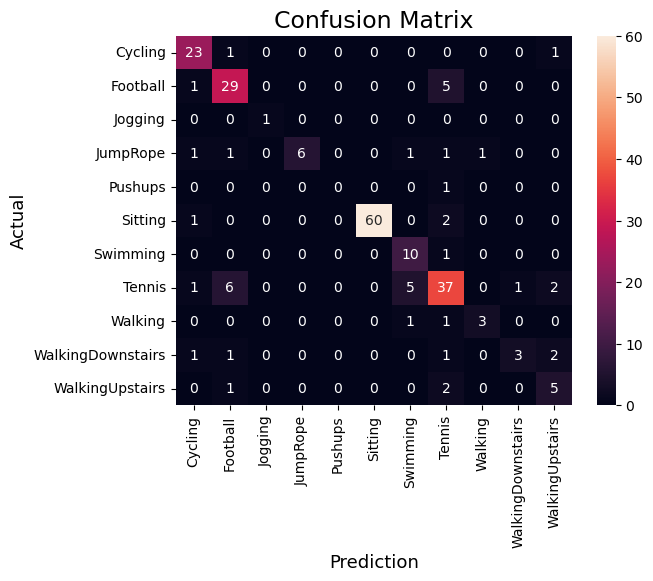

In [19]:
# load model
model = pickle.load(open(os.path.join(model_path, 'model.pkl'), 'rb'))
    
predsxgb = model.predict(dtest)
preds = np.argmax(predsxgb,axis=1)

# get labels
le = pickle.load(open(os.path.join(model_path, 'le.pkl'), 'rb'))
labels = le.inverse_transform(range(0,11))

print("Classification report")
print(classification_report(y_test, preds, labels=range(0,11), target_names=labels))
print()
print("Macro F1")
print(f1_score(y_test, preds, average='macro'))
print()
cm = confusion_matrix(y_test,preds)
sns.heatmap(cm, 
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels)
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()